# 월마트 날씨별 판매량 예측

> ### 지점-아이템-날짜 기준으로 판매량(unit) 예측!

> - 일단 test.csv파일에 나와있는 항목들만 예측하도록 한다.

> - 학습은 train.csv파일에 있는 항목으로 진행한다.

> - output 형식은 sampleSubmission.csv파일의 내용을 참고한다
    - id, units = "2_1_2013-04-01" , int


In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
#전체기후날씨데이터(weather.csv) 불러오기
weather = pd.read_csv('weather.csv')

#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [4]:
#데이터조합칸
    #store_data에 스테이션 넘버 부여
result_df = store_data.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들

#종합세팅
all_set = new_df.merge(weather, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )
#날짜데이터형변환

#숫자데이터정제




In [8]:
#데이터확인칸
# 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
# pre1_data = all_set.replace(["M",None],0)
# pre1_data = pre1_data.apply(pd.to_numeric, errors = 'ignore')
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환


In [11]:
all_set.head()

,date,store_nbr,station_nbr,item_nbr,units,tmax,tmin,tavg,depart,dewpoint,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,1,1,1,0,52,31,42,M,36,...,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2012-01-01,1,1,2,0,52,31,42,M,36,...,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
2,2012-01-01,1,1,3,0,52,31,42,M,36,...,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
3,2012-01-01,1,1,4,0,52,31,42,M,36,...,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
4,2012-01-01,1,1,5,0,52,31,42,M,36,...,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6


In [20]:
#날씨테이블만 정리-도출하는 함수 제작-----------------------------------
#----1.기간-스테이션별 요소값 df도출 함수
#----2.기간-평균값 df도출 함수

#-------특정 날씨요소값의 날짜-관측소 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'ignore')

    return station_table
    


#--------날짜별 (숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M",None],0)
    station_itm_ = temp_df.apply(pd.to_numeric, errors = 'ignore')

    # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')
    
    return avg_df
    


#=============================================================================

#지점별 avgspeed테이블 만들기 + mean speed 행 만들기--------------------------------
# station_wth = pd.DataFrame(weather,columns=["station_nbr","date","avgspeed"])


# station_speed = station_wth.pivot("date","station_nbr","avgspeed")
# station_speed = station_speed.replace(["M",None],0)

# station_speed = station_speed.astype(int, errors='ignore')



#----------이제 함수를 써보자!
station_depart = weather_pivot("depart")
station_dewpoint_avg = weather_mean("dewpoint")

In [25]:
station_dewpoint_avg

,dewpoint
date,
2012-01-01,32.105263
2012-01-02,21.631579
2012-01-03,15.421053
2012-01-04,20.842105
2012-01-05,28.578947
2012-01-06,35.578947
2012-01-07,34.210526
2012-01-08,33.789474
2012-01-09,32.368421


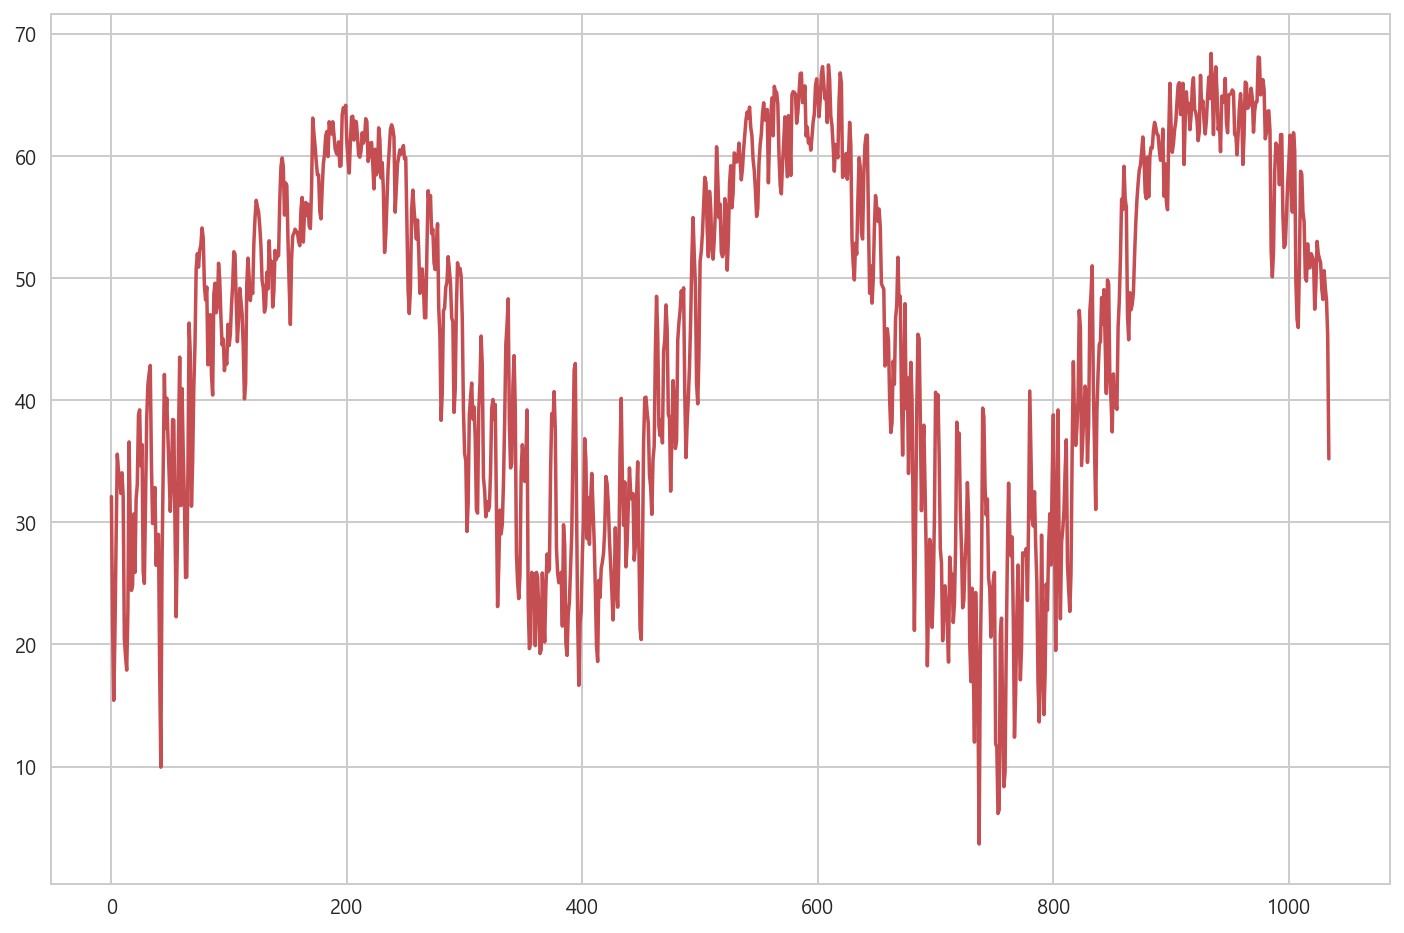

In [26]:
# 지역별 Heat/전체평균 비교 시각화

plt.figure(figsize=(12,8))

#개별데이터
# y1 = station_heat[1]
# y2 = station_heat[18]
# y3 = station_heat[20]

#전체평균온도
# Ya = avg_heat["heat"]
Y_dew = station_dewpoint_avg["dewpoint"]

plt.plot(range(len(Y_dew)),Y_dew, "r")
# plt.yticks([0,10,20,30,40,50,60])
# plt.scatter([range(len(y1)),range(len(y2)),range(len(y3))],[y1,y2,y3],c=["b","g","r"])

plt.show()

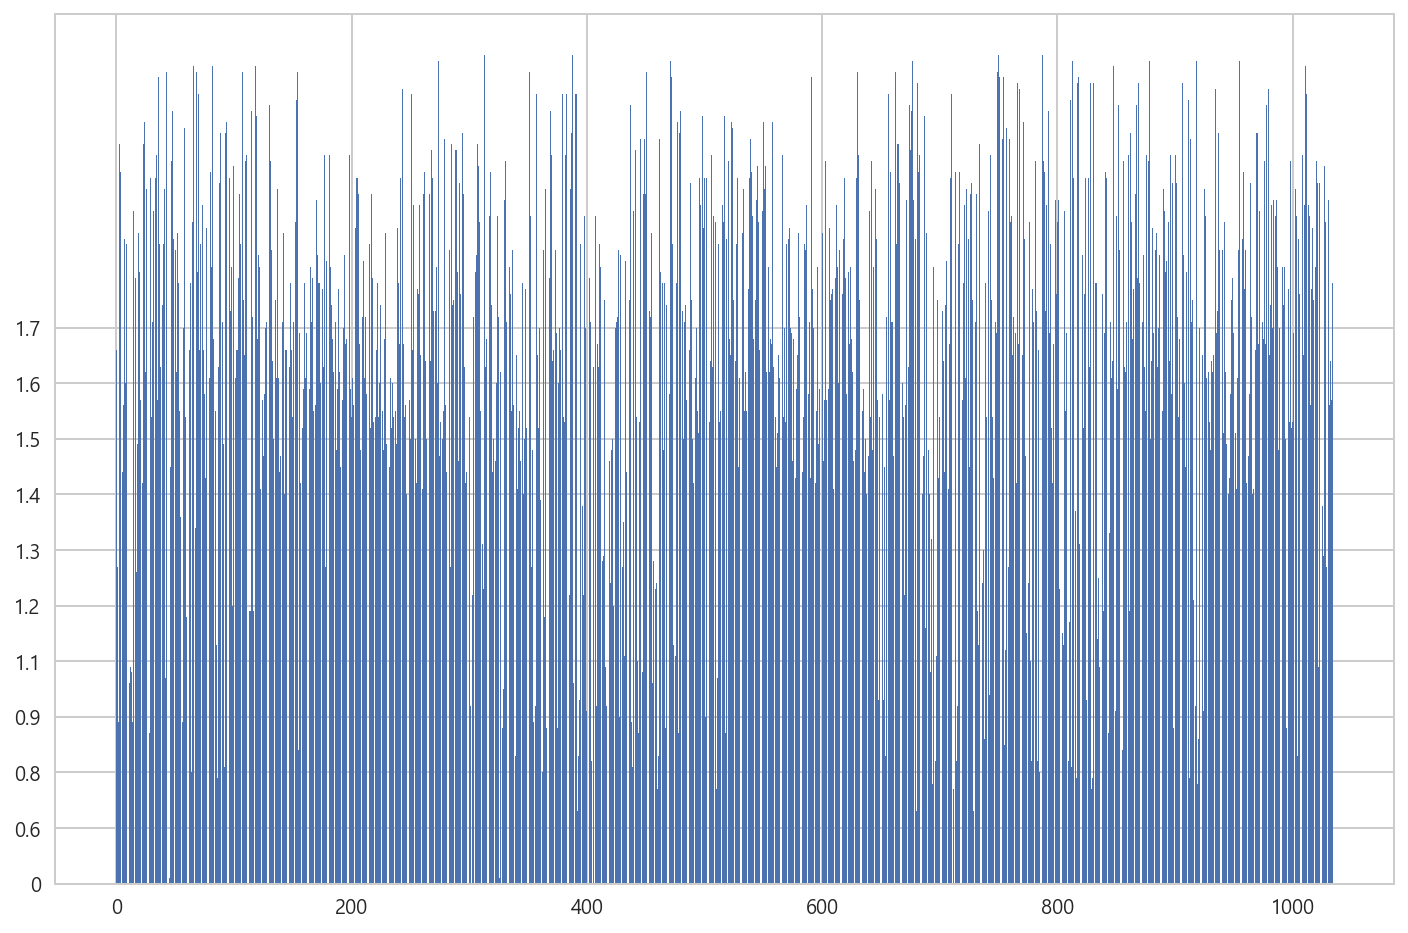

In [44]:
plt.figure(figsize=(12,8))
y1 = station_speed[1]
y2 = station_speed[18]
y3 = station_speed[20]
plt.bar(range(len(y1)),y1)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
# plt.scatter([range(len(y1)),range(len(y2)),range(len(y3))],[y1,y2,y3],c=["b","g","r"])

plt.show()